In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [89]:
from IPython.display import Audio, display

def training_done():
    display(Audio(os.path.join("../", "ice-cubes-glass-daniel_simon.wav"), autoplay=True))

In [4]:
data_folder = "../data"
predictions_folder = "../predictions"
train_file = os.path.join(data_folder, "train_clean.csv")
test_file = os.path.join(data_folder, "test_clean.csv")

In [5]:
all_data = pd.read_csv(train_file)

In [6]:
test_data = pd.read_csv(test_file)
X_test = test_data['signal'].values.reshape(-1, 1)

In [7]:
all_data.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [8]:
all_data.shape

(5000000, 3)

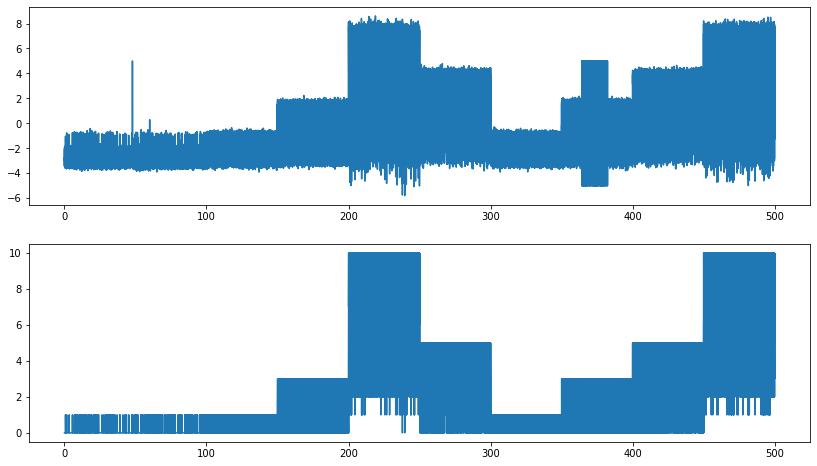

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
ax[0].plot(all_data["time"], all_data["signal"])
ax[1].plot(all_data["time"], all_data["open_channels"])

In [10]:
X = all_data['signal'].values
y = all_data['open_channels'].values

In [11]:
from sklearn.metrics import f1_score, make_scorer

def partial_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

macro_f1 = make_scorer(partial_f1_score)

In [12]:
np.random.seed(2383)
random_permutation = np.random.choice(len(X), 100000)
X_small = X[random_permutation]
y_small = y[random_permutation]

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

for i in [150, 200, 250]:
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small.reshape(-1,1), y_small, cv=5, scoring=macro_f1)

    print(f'i = {i} mean_score: {np.mean(cv_scores)}')

i = 150 mean_score: 0.7592419075414762
i = 200 mean_score: 0.75953788777368
i = 250 mean_score: 0.7597205612707375


First try at predicting test targets with a trained KNN classifier, n_neighbors = 100.

In [12]:
knn_200 = KNeighborsClassifier(n_neighbors=200)
knn_200.fit(X.reshape(-1, 1), y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [13]:
predictions = knn_200.predict(X_test)

In [14]:
predictions_df = test_data.copy(deep=True)
predictions_df['open_channels'] = predictions
predictions_df = predictions_df[['time', 'open_channels']]
predictions_df.to_csv(os.path.join(predictions_folder, "knn_200.csv"), index=False, float_format='%07.4f')

In [15]:
X_test.shape

(2000000, 1)

# Filtering the data

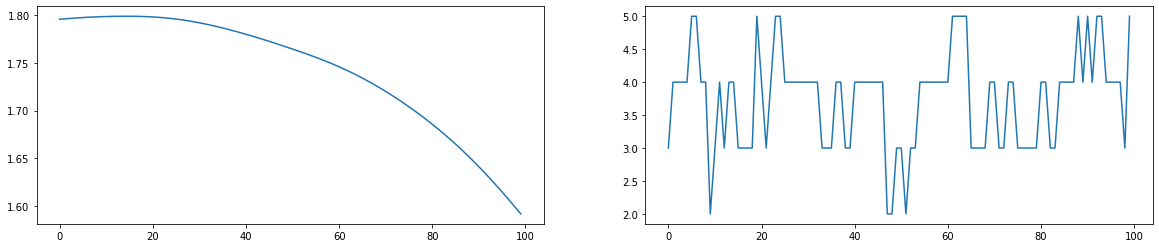

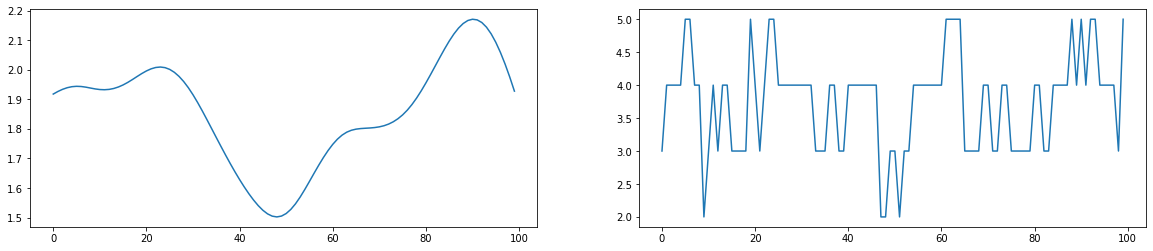

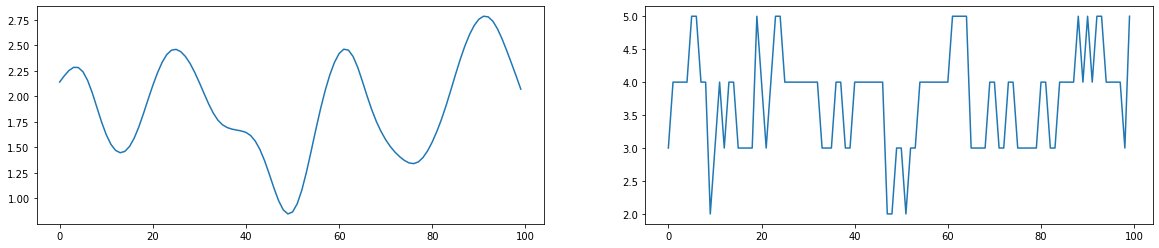

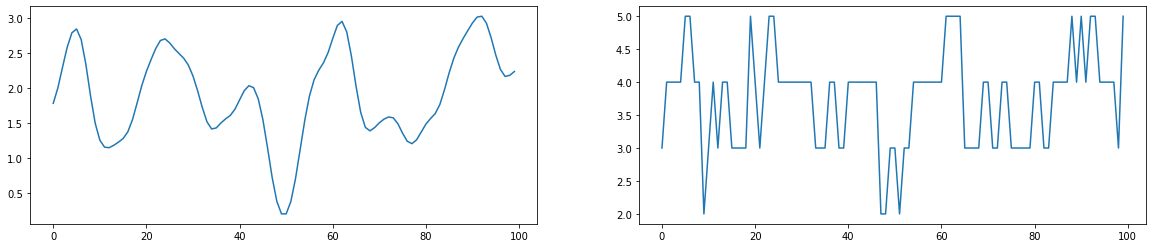

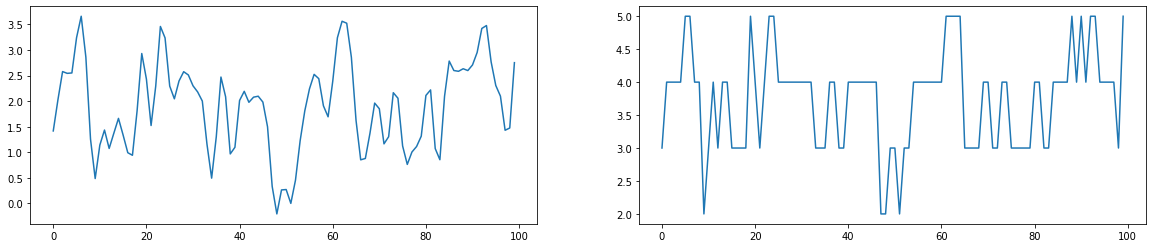

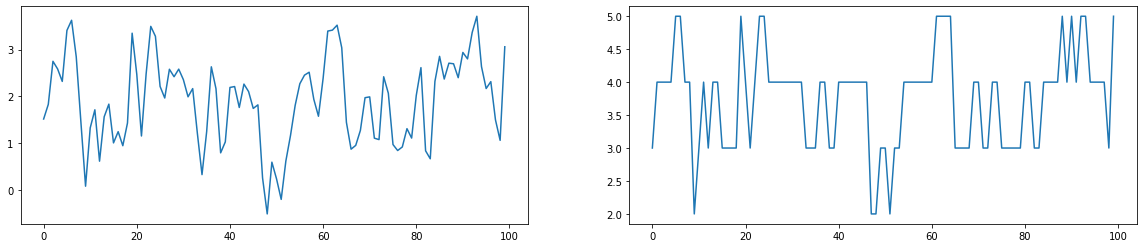

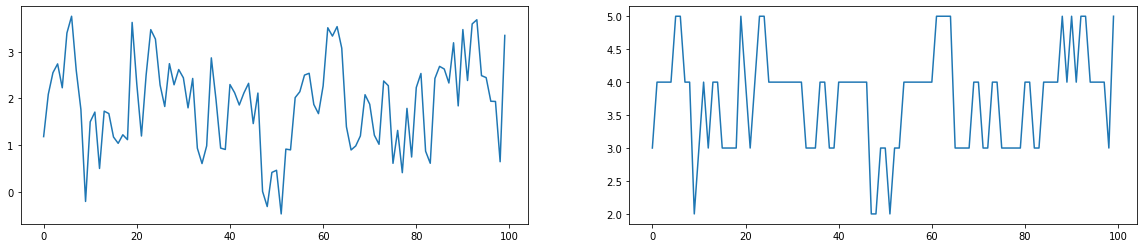

In [60]:
from filter_signal import filter_data

filtered_signal = {}
for f in [50, 200, 500, 1000, 3000, 4000, 4999]:
    filtered_signal[f] = filter_data(X, btype="low", cutoff=f)
    x_min = 4000900
    x_max = x_min+100
    z = filtered_signal[f][x_min:x_max]
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    ax[0].plot(range(len(z)), z)
    ax[1].plot(range(len(z)), y[x_min:x_max])

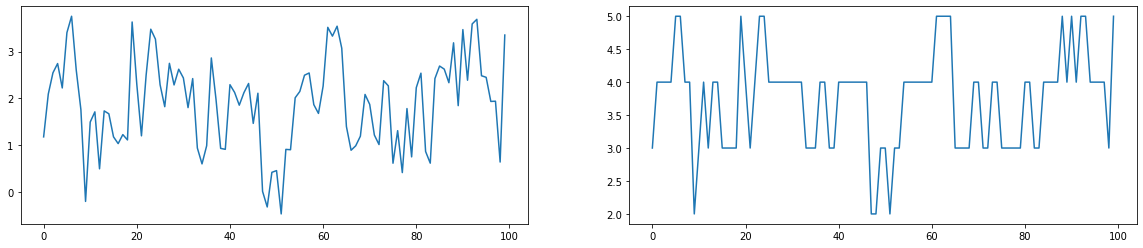

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
z = X[x_min:x_max]
ax[0].plot(range(len(z)), z)
ax[1].plot(range(len(z)), y[x_min:x_max])

In [61]:
filtered_signal[-1] = X

for f in [-1, 3000, 4000, 4999]:
    X_small = filtered_signal[f][random_permutation]
    knns_filtered = KNeighborsClassifier(n_neighbors=200, algorithm="kd_tree")
    cv_scores = cross_val_score(knns_filtered, X_small.reshape(-1,1), y_small, cv=5, scoring=macro_f1)

    print(f'cutoff freq = {f} mean_score: {np.mean(cv_scores)}')

cutoff freq = -1 mean_score: 0.75953788777368


C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cutoff freq = 3000 mean_score: 0.6764563182085572
cutoff freq = 4000 mean_score: 0.7154834118925301
cutoff freq = 4999 mean_score: 0.7586530480183251


Unfortunately it looks like low-pass filtering, even with high cutoff frequencies, removes too much information from the signal and worsens the predictions.

# Adding previous and next time step values as predictors

In [29]:
all_data.head()

,time,signal,open_channels,previous_signal,next_signal
0,0.0001,-2.7600,0,NaN,-2.8557
1,0.0002,-2.8557,0,-2.7600,-2.4074
2,0.0003,-2.4074,0,-2.8557,-3.1404
3,0.0004,-3.1404,0,-2.4074,-3.1525
4,0.0005,-3.1525,0,-3.1404,-2.6418


In [28]:
all_data['previous_signal'] = np.insert(all_data['signal'].iloc[0:-1].values, 0, np.nan)
all_data['next_signal'] = np.append(all_data['signal'].iloc[1:].values, np.nan)

In [30]:
all_data = all_data[['time', 'previous_signal', 'signal', 'next_signal', 'open_channels']]

In [31]:
all_data.head()

,time,previous_signal,signal,next_signal,open_channels
0,0.0001,NaN,-2.7600,-2.8557,0
1,0.0002,-2.7600,-2.8557,-2.4074,0
2,0.0003,-2.8557,-2.4074,-3.1404,0
3,0.0004,-2.4074,-3.1404,-3.1525,0
4,0.0005,-3.1404,-3.1525,-2.6418,0


In [32]:
all_data.tail()

,time,previous_signal,signal,next_signal,open_channels
4999995,499.9996,4.371143,2.919274,2.697906,7
4999996,499.9997,2.919274,2.697906,4.516337,7
4999997,499.9998,2.697906,4.516337,5.639669,8
4999998,499.9999,4.516337,5.639669,5.379200,9
4999999,500.0000,5.639669,5.379200,NaN,9


In [33]:
X = all_data[['previous_signal', 'signal', 'next_signal']].iloc[1:-1].values

In [34]:
X

array([[-2.76      , -2.8557    , -2.4074    ],
       [-2.8557    , -2.4074    , -3.1404    ],
       [-2.4074    , -3.1404    , -3.1525    ],
       ...,
       [ 2.91927434,  2.69790575,  4.51633717],
       [ 2.69790575,  4.51633717,  5.63966858],
       [ 4.51633717,  5.63966858,  5.3792    ]])

In [35]:
y = all_data['open_channels'].iloc[1:-1].values

In [38]:
X_small.shape

(100000, 3)

In [39]:
y_small.shape

(100000,)

In [36]:
random_permutation = np.random.choice(len(X), 100000)
X_small = X[random_permutation]
y_small = y[random_permutation]

In [45]:
for i in [10, 20, 30, 50]:
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small[:, 1:], y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with current+next mean_score: {np.mean(cv_scores)}')
    
for i in [10, 20, 30, 50]:
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small[:, 1:], y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with previous+current mean_score: {np.mean(cv_scores)}')

for i in [10, 20, 30, 50]:
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small, y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with previous+current+next mean_score: {np.mean(cv_scores)}')

i = 10 with current+next mean_score: 0.798194809106812
i = 20 with current+next mean_score: 0.8011499401105239
i = 30 with current+next mean_score: 0.8023895761878592
i = 50 with current+next mean_score: 0.8024702988347
i = 10 with previous+current mean_score: 0.798194809106812
i = 20 with previous+current mean_score: 0.8011499401105239
i = 30 with previous+current mean_score: 0.8023895761878592
i = 50 with previous+current mean_score: 0.8024702988347
i = 10 with previous+current+next mean_score: 0.8200300158996005
i = 20 with previous+current+next mean_score: 0.8231725381362235
i = 30 with previous+current+next mean_score: 0.8226047943915742
i = 50 with previous+current+next mean_score: 0.8186593925082176


Looks like using previous, current AND next signal value gives a significant 2% score increase over using only current+previous or current+next, and a 6% increase over using only current signal.
Let's try to add even more with previous_2 and next_2.

In [46]:
two_nans = np.empty(2)
two_nans[:] = np.nan
all_data['previous_signal_2'] = np.insert(all_data['signal'].iloc[0:-2].values, 0, two_nans)
all_data['next_signal_2'] = np.append(all_data['signal'].iloc[2:].values, two_nans)
all_data = all_data[['time', 'previous_signal_2', 'previous_signal', 'signal', 'next_signal', 'next_signal_2', 'open_channels']]

C:\Users\ribau\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ribau\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
all_data.head()

,time,previous_signal_2,previous_signal,signal,next_signal,next_signal_2,open_channels
0,0.0001,NaN,NaN,-2.7600,-2.8557,-2.4074,0
1,0.0002,NaN,-2.7600,-2.8557,-2.4074,-3.1404,0
2,0.0003,-2.7600,-2.8557,-2.4074,-3.1404,-3.1525,0
3,0.0004,-2.8557,-2.4074,-3.1404,-3.1525,-2.6418,0
4,0.0005,-2.4074,-3.1404,-3.1525,-2.6418,-2.6993,0


In [48]:
all_data.tail()

,time,previous_signal_2,previous_signal,signal,next_signal,next_signal_2,open_channels
4999995,499.9996,4.191312,4.371143,2.919274,2.697906,4.516337,7
4999996,499.9997,4.371143,2.919274,2.697906,4.516337,5.639669,7
4999997,499.9998,2.919274,2.697906,4.516337,5.639669,5.379200,8
4999998,499.9999,2.697906,4.516337,5.639669,5.379200,NaN,9
4999999,500.0000,4.516337,5.639669,5.379200,NaN,NaN,9


In [ ]:
three_nan = np.full(3, np.nan)
all_data['previous_signal_3'] = np.insert(all_data['signal'].iloc[0:-3].values, 0, three_nan)
all_data['next_signal_3'] = np.append(all_data['signal'].iloc[3:].values, three_nan)
all_data = all_data[['time', 'previous_signal_3', 'previous_signal_2', 'previous_signal', 'signal', 'next_signal', 'next_signal_2', 'next_signal_3', 'open_channels']]

In [106]:
X = all_data[['previous_signal','signal', 'next_signal']].iloc[2:-2].values
y = all_data['open_channels'].iloc[1:-1].values

np.random.seed(2383)
random_permutation = np.random.choice(len(X), 1000000, replace=False)
X_small = X[random_permutation]
y_small = y[random_permutation]
for i in range(25, 75, 5):
    knns_class = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=i))])
    cv_scores = cross_val_score(knns_class, X_small, y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with previous+current+next mean_score: {np.mean(cv_scores)}')
    
training_done()

i = 25 with previous+current+next mean_score: 0.8297001185740662
i = 30 with previous+current+next mean_score: 0.8295657533763598
i = 35 with previous+current+next mean_score: 0.8298015150287708
i = 40 with previous+current+next mean_score: 0.8301429017549754
i = 45 with previous+current+next mean_score: 0.8304286631548441
i = 50 with previous+current+next mean_score: 0.8300498788923832
i = 55 with previous+current+next mean_score: 0.8301851894968131
i = 60 with previous+current+next mean_score: 0.830299212019064
i = 65 with previous+current+next mean_score: 0.8300402630713759
i = 70 with previous+current+next mean_score: 0.829898743094575


In [104]:
X = all_data[['previous_signal_2', 'previous_signal','signal', 'next_signal', 'next_signal_2']].iloc[2:-2].values
y = all_data['open_channels'].iloc[2:-2].values

np.random.seed(2383)
random_permutation = np.random.choice(len(X), 1000000, replace=False)
X_small = X[random_permutation]
y_small = y[random_permutation]

for i in range(1, 50, 5):
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small, y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with 2previous+current+2next mean_score: {np.mean(cv_scores)}')
    
training_done()

i = 1 with 2previous+current+2next mean_score: 0.8043844951190321
i = 6 with 2previous+current+2next mean_score: 0.8392784547037442
i = 11 with 2previous+current+2next mean_score: 0.8460581625503716
i = 16 with 2previous+current+2next mean_score: 0.8455202629371552
i = 21 with 2previous+current+2next mean_score: 0.8458153592777193
i = 26 with 2previous+current+2next mean_score: 0.8446727387079079
i = 31 with 2previous+current+2next mean_score: 0.8442642303442034
i = 36 with 2previous+current+2next mean_score: 0.8427435416741496
i = 41 with 2previous+current+2next mean_score: 0.841803864054989
i = 46 with 2previous+current+2next mean_score: 0.8406926295512157


In [107]:
X = all_data[['previous_signal_3', 'previous_signal_2', 'previous_signal','signal', 'next_signal', 'next_signal_2', 'next_signal_3']].iloc[3:-3].values
y = all_data['open_channels'].iloc[3:-3].values

np.random.seed(2383)
random_permutation = np.random.choice(len(X), 1000000, replace=False)
X_small = X[random_permutation]
y_small = y[random_permutation]

for i in range(6, 16, 2):
    knns_class = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(knns_class, X_small, y_small, cv=5, scoring=macro_f1)
    print(f'i = {i} with 3previous+current+3next mean_score: {np.mean(cv_scores)}')
    
training_done()

i = 6 with 3previous+current+3next mean_score: 0.8310579920413332
i = 8 with 3previous+current+3next mean_score: 0.8328368516153078
i = 10 with 3previous+current+3next mean_score: 0.8345186796283406
i = 12 with 3previous+current+3next mean_score: 0.8339898073900809
i = 14 with 3previous+current+3next mean_score: 0.83335244888375


In [71]:
def nlogn(x):
    return np.log(x)*x

n1 = 100000
n2 = len(all_data)

print(f'{nlogn(n2)/nlogn(n1)}')

66.98970004336019


Since the KNN implementation of scikit-learn is in O(n\*log(n)), we should expect a factor 67 in the training time over the full set against the training on random batches that we are doing here.

It's not easy to choose the best features for our training because the more features you add, the more valuable the training set size is. Here we are training on smaller batches than the whole training set, because training KNN once of the whole training set will be very long, and won't allow to tune K or the features that we want to use.

In [108]:
from joblib import dump, load

X = all_data[['previous_signal_2', 'previous_signal','signal', 'next_signal', 'next_signal_2']].iloc[2:-2].values
y = all_data['open_channels'].iloc[2:-2].values

knns_class = KNeighborsClassifier(n_neighbors=11)
knns_class.fit(X, y)

dump(knns_class, 'knn_5features_k11.joblib')
    
training_done()

In [114]:
y_pred

array([0, 0, 0, ..., 7, 7, 8], dtype=int64)

In [117]:
partial_f1_score(y, y_pred)

0.8740908665044089

In [123]:
first_val = test_data['signal'].iloc[0]
last_val = test_data['signal'].iloc[-1]
first_val_twice = np.full(2, first_val)
last_val_twice = np.full(2, last_val)
test_data['previous_signal'] = np.insert(test_data['signal'].iloc[0:-1].values, 0, first_val)
test_data['next_signal'] = np.append(test_data['signal'].iloc[1:].values, last_val)
test_data['previous_signal_2'] = np.insert(test_data['signal'].iloc[0:-2].values, 0, first_val_twice)
test_data['next_signal_2'] = np.append(test_data['signal'].iloc[2:].values, last_val_twice)
test_data = test_data[['time', 'previous_signal_2', 'previous_signal', 'signal', 'next_signal', 'next_signal_2']]
X_test = test_data.values[:,1:]
y_pred_test = knns_class.predict(X_test)

In [124]:
predictions_df = test_data[['time']].copy(deep=True)
predictions_df['open_channels'] = y_pred_test
predictions_df.to_csv(os.path.join(predictions_folder, "knn_5feat_k11.csv"), index=False, float_format='%07.4f')